In [29]:
import re
import numpy as np
from keras.preprocessing import image
from keras.models import Model
from PIL import Image
import pickle
import os
from pickle import dump,load
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras import Input, layers
from keras import optimizers
from time import time
import glob
from numpy import array

In [2]:
p = "Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
np="Flickr_Data/Flickr_TextData/description.txt"
path = "Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt"
path2 = "Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt"
images = "Flickr_Data/Images/"

In [3]:
fr = open(p,mode="r").read().split('\n')
d = {}
for i in range(len(fr)):
    t = fr[i].split()
    img_id = t[0]
    img_desc = t[1:]
    img_id = img_id.split('.')[0]
    img_desc = ' '.join(img_desc)
    if img_id not in d:
        d[img_id] = list()
    d[img_id].append(img_desc)

IndexError: list index out of range

In [4]:
print("loaded descriptions ",len(d))
print(list(d.keys())[:5])
print(d['3214237686_6566b8b52f'])
for value in d.values():
    for i in range(len(value)):
        v = value[i]
        v = re.sub('[^a-zA-Z]',' ',v)
        v = v.lower()
        v = v.split()
        v = [word for word in v if len(word)>1]
        value[i] = ' '.join(v)

loaded descriptions  8092
['401476986_73918145a3', '300371487_daec5d11ab', '2662262499_3cdf49cedd', '482907079_22085ada04', '495055747_a75872762a']
['a lone snowboarder jumping in the air doing a trick .', 'A man in black is taking a jump on a snowboard .', 'A person riding a snowboard jumps high over the snowy hill .', 'A person with a yellow and black striped snowboard jumps on the snowy hill .', 'a snowboarder jumps off the snow jump .']


In [5]:
l = list()
for key,value in d.items():
    for v in value:
        l.append(key+' '+v)
x = '\n'.join(l)
nfr = open(np,mode='w').write(x)

In [6]:
f = open(path,mode='r').read().split('\n')
train = list()
for i in range(len(f)):
    t = f[i].split('.')[0]
    train.append(t)
print(len(train))

6001


In [7]:
nf = open(np,mode='r').read().split('\n')
desc = {}
for i in range(len(nf)):
    t = nf[i].split()
    img_id,img_desc = t[0],t[1:]
    if img_id in train:
        if img_id not in desc:
            desc[img_id] = list()
        seq = 'start '+' '.join(img_desc)+' end'
        desc[img_id].append(seq)

In [8]:
print(desc)

{'401476986_73918145a3': ['start big dog is running in the grassy field with woods behind him end', 'start dog runs across the land end', 'start german shepherd jumping in midair end', 'start german shepherd leaps in midair end', 'start black and brown dog runs through field end'], '300371487_daec5d11ab': ['start brown dog playing outside with pink ball end', 'start brown dog running after red ball end', 'start dog chasing pink ball end', 'start brown dog catches pink ball in the park end', 'start brown dog chasing pink ball end'], '2662262499_3cdf49cedd': ['start baseball hitter holding bat falling down end', 'start baseball player runs on the field end', 'start boy at bat playing baseball game falls to the ground while onlookers watch end', 'start child in uniform is falling to the ground with bat in his or her hand end', 'start this baseball player dressed in red and white uniform and holding bat is falling after being hit by pitch end'], '3647693147_0d0434351b': ['start boy throws 

In [9]:
train_captions =[]
for key,val in desc.items():
    for cap in val:
        train_captions.append(cap)
word_threshold = 10
word_count = {}
n=0
for sent in train_captions:
    n+=1
    for w in sent.split(" "):
        word_count[w]=word_count.get(w,0) + 1
vocab = [w for w in word_count if word_count[w] >= word_threshold]
vocab_size = len(vocab)
print(vocab_size)  

1655


In [10]:
model = InceptionV3(weights='imagenet')

In [11]:
new_model= Model(model.input,model.layers[-2].output)

In [12]:
imgp = glob.glob(images + '*jpg')
print(len(imgp))

8091


In [13]:
ti = set(open(path,mode='r').read().strip().split('\n'))
train_img = []

for i in imgp: 
    if i[len(images):] in ti:
        train_img.append(i)

ti2 = set(open(path2,mode='r').read().strip().split('\n'))
test_img = []

for i in imgp: 
    if i[len(images):] in ti2: 
        test_img.append(i)
print(len(train_img))
print(len(test_img))

6000
1000


In [14]:
def preprocess(imgp):
    img = image.load_img(imgp, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [15]:
def encode(imgp):
    image = preprocess(imgp) # preprocess the image
    fea_vec = new_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [74]:
#no
start = time()
print(start)
encoding_train = {}
for imgp in train_img:
    encoding_train[imgp[len(images):]] = encode(imgp)
    print(imgp)
print("Time taken in seconds =", time()-start)

1580358969.1938677
Flickr_Data/Images\1000268201_693b08cb0e.jpg
Flickr_Data/Images\1001773457_577c3a7d70.jpg
Flickr_Data/Images\1002674143_1b742ab4b8.jpg
Flickr_Data/Images\1003163366_44323f5815.jpg
Flickr_Data/Images\1007129816_e794419615.jpg
Flickr_Data/Images\1007320043_627395c3d8.jpg
Flickr_Data/Images\1009434119_febe49276a.jpg
Flickr_Data/Images\1012212859_01547e3f17.jpg
Flickr_Data/Images\1015118661_980735411b.jpg
Flickr_Data/Images\1015584366_dfcec3c85a.jpg
Flickr_Data/Images\101654506_8eb26cfb60.jpg
Flickr_Data/Images\101669240_b2d3e7f17b.jpg
Flickr_Data/Images\1016887272_03199f49c4.jpg
Flickr_Data/Images\1019077836_6fc9b15408.jpg
Flickr_Data/Images\1019604187_d087bf9a5f.jpg
Flickr_Data/Images\1020651753_06077ec457.jpg
Flickr_Data/Images\1022454428_b6b660a67b.jpg
Flickr_Data/Images\1022975728_75515238d8.jpg
Flickr_Data/Images\102351840_323e3de834.jpg
Flickr_Data/Images\1024138940_f1fefbdce1.jpg
Flickr_Data/Images\102455176_5f8ead62d5.jpg
Flickr_Data/Images\1026685415_0431cbf574

Flickr_Data/Images\1277743944_f4e8c78403.jpg
Flickr_Data/Images\1280147517_98767ca3b3.jpg
Flickr_Data/Images\1280320287_b2a4b9b7bd.jpg
Flickr_Data/Images\12830823_87d2654e31.jpg
Flickr_Data/Images\1285067106_2adc307240.jpg
Flickr_Data/Images\1285874746_486731a954.jpg
Flickr_Data/Images\1286408831_05282582ed.jpg
Flickr_Data/Images\1287064529_aa4e4f3c31.jpg
Flickr_Data/Images\1287920676_d21a0b289b.jpg
Flickr_Data/Images\1287931016_fb015e2e10.jpg
Flickr_Data/Images\1287982439_6578006e22.jpg
Flickr_Data/Images\1288909046_d2b2b62607.jpg
Flickr_Data/Images\128912885_8350d277a4.jpg
Flickr_Data/Images\1289142574_2bd6a082dd.jpg
Flickr_Data/Images\1290894194_8a4ffdc7eb.jpg
Flickr_Data/Images\1294578091_2ad02fea91.jpg
Flickr_Data/Images\1295669416_21cabf594d.jpg
Flickr_Data/Images\1295671216_cde1b9c9d1.jpg
Flickr_Data/Images\129599450_cab4e77343.jpg
Flickr_Data/Images\1296412797_85b6d2f8d6.jpg
Flickr_Data/Images\1296770308_3db2022f5a.jpg
Flickr_Data/Images\1298866571_b4c496b71c.jpg
Flickr_Data/Im

Flickr_Data/Images\1452361926_6d8c535e32.jpg
Flickr_Data/Images\1453366750_6e8cf601bf.jpg
Flickr_Data/Images\1454678644_7e5a371301.jpg
Flickr_Data/Images\1454841725_4b6e6199e2.jpg
Flickr_Data/Images\1456630952_dd4778a48f.jpg
Flickr_Data/Images\145721496_687af9bb18.jpg
Flickr_Data/Images\1457762320_7fe121b285.jpg
Flickr_Data/Images\1459032057_97e73ed6ab.jpg
Flickr_Data/Images\1460352062_d64fb633e0.jpg
Flickr_Data/Images\1460500597_866fa0c6f3.jpg
Flickr_Data/Images\146100443_906d87faa2.jpg
Flickr_Data/Images\1461329041_c623b06e5b.jpg
Flickr_Data/Images\1461653394_8ab96aae63.jpg
Flickr_Data/Images\1463638541_c02cfa04dc.jpg
Flickr_Data/Images\1463732130_a754441289.jpg
Flickr_Data/Images\1463732807_0cdf4f22c7.jpg
Flickr_Data/Images\1464120327_d90279ca3a.jpg
Flickr_Data/Images\1465666502_de289b3b9c.jpg
Flickr_Data/Images\146577645_91b570c0d0.jpg
Flickr_Data/Images\146577646_9e64b8c2dc.jpg
Flickr_Data/Images\1466307485_5e6743332e.jpg
Flickr_Data/Images\1466307489_cb8a74de09.jpg
Flickr_Data/Im

Flickr_Data/Images\1809796012_a2dac6c26b.jpg
Flickr_Data/Images\1810651611_35aae644fb.jpg
Flickr_Data/Images\181103691_fb2f956abd.jpg
Flickr_Data/Images\181157221_e12410ef0b.jpg
Flickr_Data/Images\1812525037_528465037c.jpg
Flickr_Data/Images\1813266419_08bf66fe98.jpg
Flickr_Data/Images\1813597483_3f09d2a020.jpg
Flickr_Data/Images\1813777902_07d1d4b00c.jpg
Flickr_Data/Images\1814086703_33390d5fc7.jpg
Flickr_Data/Images\181415975_2627aa6668.jpg
Flickr_Data/Images\1814391289_83a1eb71d3.jpg
Flickr_Data/Images\181777261_84c48b31cb.jpg
Flickr_Data/Images\1818403842_553a2a392c.jpg
Flickr_Data/Images\1819261140_6c022f4b1d.jpg
Flickr_Data/Images\1821238649_2fda79d6d7.jpg
Flickr_Data/Images\182493240_40410254b0.jpg
Flickr_Data/Images\1827560917_c8d3c5627f.jpg
Flickr_Data/Images\1835511273_790eaae6e6.jpg
Flickr_Data/Images\1837976956_3c45d0f9b8.jpg
Flickr_Data/Images\185057637_e8ada37343.jpg
Flickr_Data/Images\1858963639_4588cd4be9.jpg
Flickr_Data/Images\185972340_781d60ccfd.jpg
Flickr_Data/Image

Flickr_Data/Images\2089539651_9e518ec7de.jpg
Flickr_Data/Images\2089542487_b4c1ee7025.jpg
Flickr_Data/Images\2089555297_95cf001fa7.jpg
Flickr_Data/Images\2090327868_9f99e2740d.jpg
Flickr_Data/Images\2090386465_b6ebb7df2c.jpg
Flickr_Data/Images\2090723611_318031cfa5.jpg
Flickr_Data/Images\2091171488_c8512fec76.jpg
Flickr_Data/Images\2092419948_eea8001d0f.jpg
Flickr_Data/Images\2092870249_90e3f1855b.jpg
Flickr_Data/Images\2094543127_46d2f1fedf.jpg
Flickr_Data/Images\2094810449_f8df9dcdf7.jpg
Flickr_Data/Images\2095007523_591f255708.jpg
Flickr_Data/Images\2095078658_c14ba89bc2.jpg
Flickr_Data/Images\2095435987_1b7591d214.jpg
Flickr_Data/Images\2095478050_736c4d2d28.jpg
Flickr_Data/Images\209605542_ca9cc52e7b.jpg
Flickr_Data/Images\2097398349_ff178b3f1b.jpg
Flickr_Data/Images\2097407245_c798e0dcaf.jpg
Flickr_Data/Images\2097420505_439f63c863.jpg
Flickr_Data/Images\2098174172_e57d86ea03.jpg
Flickr_Data/Images\2098418613_85a0c9afea.jpg
Flickr_Data/Images\2098646162_e3b3bbf14c.jpg
Flickr_Data

Flickr_Data/Images\2214847438_4993210d4c.jpg
Flickr_Data/Images\2215165918_2bf5b659dd.jpg
Flickr_Data/Images\2216568822_84c295c3b0.jpg
Flickr_Data/Images\2217728745_92b6779016.jpg
Flickr_Data/Images\2218334049_e649dbdb1a.jpg
Flickr_Data/Images\2218519240_cac5aab53c.jpg
Flickr_Data/Images\2218743570_9d6614c51c.jpg
Flickr_Data/Images\221973402_ecb1cd51f1.jpg
Flickr_Data/Images\2219805467_370ee1b7aa.jpg
Flickr_Data/Images\2219805677_7b7cc188c7.jpg
Flickr_Data/Images\2219959872_988e6d498e.jpg
Flickr_Data/Images\2220175999_081aa9cce8.jpg
Flickr_Data/Images\2220185725_45d4fa68d9.jpg
Flickr_Data/Images\2220612655_030413b787.jpg
Flickr_Data/Images\2222498879_9e82a100ab.jpg
Flickr_Data/Images\2222559267_6fd31e3941.jpg
Flickr_Data/Images\2223382277_9efa58ec45.jpg
Flickr_Data/Images\222369445_5b6af347dd.jpg
Flickr_Data/Images\2224995194_518859d97d.jpg
Flickr_Data/Images\2225241766_f1e7132e3e.jpg
Flickr_Data/Images\2226440063_c085b30558.jpg
Flickr_Data/Images\2226534154_cbcab7ba32.jpg
Flickr_Data/

Flickr_Data/Images\2298097636_c5de0079de.jpg
Flickr_Data/Images\2298283771_fb21a4217e.jpg
Flickr_Data/Images\2298661279_016d87ba2f.jpg
Flickr_Data/Images\2298946012_22de913532.jpg
Flickr_Data/Images\2299427360_422a3fb8b0.jpg
Flickr_Data/Images\229951087_4c20600c32.jpg
Flickr_Data/Images\229978782_3c690f5a0e.jpg
Flickr_Data/Images\2299859649_07ca44a222.jpg
Flickr_Data/Images\230016181_0c52b95304.jpg
Flickr_Data/Images\2300920203_f29260b1db.jpg
Flickr_Data/Images\2301379282_5fbcf230d1.jpg
Flickr_Data/Images\2301867590_98c0ecb0cb.jpg
Flickr_Data/Images\2302747917_aa0300eb68.jpg
Flickr_Data/Images\2303016989_0deb96c8d9.jpg
Flickr_Data/Images\2303356248_65dd6aba6f.jpg
Flickr_Data/Images\2303951441_3c8080907a.jpg
Flickr_Data/Images\2304374703_555195d8d5.jpg
Flickr_Data/Images\2304444199_05386d2e9c.jpg
Flickr_Data/Images\2305437797_e6c3460190.jpg
Flickr_Data/Images\2306186887_0bd8ed3792.jpg
Flickr_Data/Images\2307807200_91fa29cba1.jpg
Flickr_Data/Images\2308108566_2cba6bca53.jpg
Flickr_Data/I

Flickr_Data/Images\2394763838_99d1435b85.jpg
Flickr_Data/Images\2394919002_ed7527ff93.jpg
Flickr_Data/Images\2394922193_310166d6af.jpg
Flickr_Data/Images\2395967330_7e6ea404f6.jpg
Flickr_Data/Images\2396100671_3a9d67f03d.jpg
Flickr_Data/Images\2396669903_5217a83641.jpg
Flickr_Data/Images\2396746868_0727e06983.jpg
Flickr_Data/Images\239807547_4923efc821.jpg
Flickr_Data/Images\2399114095_c3196ff456.jpg
Flickr_Data/Images\2400958566_4e09424046.jpg
Flickr_Data/Images\2402462857_7684848704.jpg
Flickr_Data/Images\2403078014_4b1d6f8bde.jpg
Flickr_Data/Images\2403544744_cba152f5c1.jpg
Flickr_Data/Images\2404488732_ca1bbdacc2.jpg
Flickr_Data/Images\2404692474_37da774368.jpg
Flickr_Data/Images\2405599120_ec5f32af6f.jpg
Flickr_Data/Images\240583223_e26e17ee96.jpg
Flickr_Data/Images\2407091303_931c918490.jpg
Flickr_Data/Images\2407470303_6fd5e3600d.jpg
Flickr_Data/Images\2409312675_7755a7b816.jpg
Flickr_Data/Images\2410040397_1a161a1146.jpg
Flickr_Data/Images\241031670_e60f59b8e4.jpg
Flickr_Data/I

Flickr_Data/Images\246094557_e174a5914f.jpg
Flickr_Data/Images\2461372011_ebbf513766.jpg
Flickr_Data/Images\2461631708_decc5b8c87.jpg
Flickr_Data/Images\2462153092_e3f4d8f6a2.jpg
Flickr_Data/Images\2462702522_1b25654762.jpg
Flickr_Data/Images\2463067409_78188c584c.jpg
Flickr_Data/Images\2464259416_238ef13a2e.jpg
Flickr_Data/Images\246508774_1e9885f1b7.jpg
Flickr_Data/Images\2465218087_fca77998c6.jpg
Flickr_Data/Images\2465441099_a1761a1757.jpg
Flickr_Data/Images\2465497494_43d74df57c.jpg
Flickr_Data/Images\2465691083_894fc48af6.jpg
Flickr_Data/Images\2466093839_33bbc8cbd9.jpg
Flickr_Data/Images\2466171100_5e60cfcc11.jpg
Flickr_Data/Images\2466171114_3fa51415a7.jpg
Flickr_Data/Images\2466420387_86fe77c966.jpg
Flickr_Data/Images\2466495935_623b144183.jpg
Flickr_Data/Images\2467803152_70eeca1334.jpg
Flickr_Data/Images\2467821766_0510c9a2d1.jpg
Flickr_Data/Images\2467850190_07a74d89b7.jpg
Flickr_Data/Images\2467856402_0490413d38.jpg
Flickr_Data/Images\246901891_4c4ea49c3a.jpg
Flickr_Data/I

Flickr_Data/Images\2545363449_1985903f82.jpg
Flickr_Data/Images\2546667441_bbe87a6285.jpg
Flickr_Data/Images\2546959333_23b957988f.jpg
Flickr_Data/Images\2547785434_f227bd3680.jpg
Flickr_Data/Images\2548777800_d7b9cf1c2b.jpg
Flickr_Data/Images\254901702_67ada9867c.jpg
Flickr_Data/Images\2549452277_873cb80d3e.jpg
Flickr_Data/Images\2550011909_6b95f11330.jpg
Flickr_Data/Images\2550109269_bc4262bd27.jpg
Flickr_Data/Images\255091927_2eb643beb2.jpg
Flickr_Data/Images\255091930_aa2b5c0eb9.jpg
Flickr_Data/Images\2551632823_0cb7dd779b.jpg
Flickr_Data/Images\2552723989_7bc93e0f7b.jpg
Flickr_Data/Images\2552816307_c7c8e7f6b4.jpg
Flickr_Data/Images\2552949275_b8cdc450cc.jpg
Flickr_Data/Images\2553024095_735bc46267.jpg
Flickr_Data/Images\2553188198_da1123a723.jpg
Flickr_Data/Images\255330891_86d65dfdbf.jpg
Flickr_Data/Images\2554531876_5d7f193992.jpg
Flickr_Data/Images\2554570943_122da6438f.jpg
Flickr_Data/Images\2555521861_fc36fd3ab0.jpg
Flickr_Data/Images\2555535057_007501dae5.jpg
Flickr_Data/Im

Flickr_Data/Images\2629402527_6dfc5c504b.jpg
Flickr_Data/Images\2629445284_83390e83af.jpg
Flickr_Data/Images\262963190_a78b799e89.jpg
Flickr_Data/Images\2630507245_bea4804288.jpg
Flickr_Data/Images\2632111399_b3c1630f8e.jpg
Flickr_Data/Images\263216826_acf868049c.jpg
Flickr_Data/Images\263231469_e85c74f5fd.jpg
Flickr_Data/Images\263233914_d25004e4cd.jpg
Flickr_Data/Images\2632366677_43dee456a5.jpg
Flickr_Data/Images\2632381125_de32bdfdf6.jpg
Flickr_Data/Images\2633082074_32c85f532c.jpg
Flickr_Data/Images\2633201394_ee4a7666ed.jpg
Flickr_Data/Images\2633722629_5eeb649c09.jpg
Flickr_Data/Images\2635023078_6dae04758f.jpg
Flickr_Data/Images\263522013_d118d46b2d.jpg
Flickr_Data/Images\2635400219_2e1a984fd3.jpg
Flickr_Data/Images\2635483351_bc1a8273aa.jpg
Flickr_Data/Images\2635905544_dbc65d0622.jpg
Flickr_Data/Images\2635908229_b9fc90d3fb.jpg
Flickr_Data/Images\2635938723_11b85e6763.jpg
Flickr_Data/Images\2636514498_01fcc5f501.jpg
Flickr_Data/Images\2636876892_9353521a1c.jpg
Flickr_Data/Ima

Flickr_Data/Images\2708176152_1634cb754d.jpg
Flickr_Data/Images\2708582445_5e5999b956.jpg
Flickr_Data/Images\2708634088_a4686be24c.jpg
Flickr_Data/Images\270864951_1737ae5479.jpg
Flickr_Data/Images\2708744743_e231f7fcf9.jpg
Flickr_Data/Images\2709275718_73fcf08c23.jpg
Flickr_Data/Images\2709536455_2a6046e38a.jpg
Flickr_Data/Images\2709648336_15455e60b2.jpg
Flickr_Data/Images\2709683703_5385ea9ef4.jpg
Flickr_Data/Images\2710280476_dcccb8745a.jpg
Flickr_Data/Images\2710698257_2e4ca8dd44.jpg
Flickr_Data/Images\2711075591_f3ee53cfaa.jpg
Flickr_Data/Images\2711720095_0b98426d3c.jpg
Flickr_Data/Images\271177682_48da79ab33.jpg
Flickr_Data/Images\2712352554_1cafd32812.jpg
Flickr_Data/Images\2712974062_6d5b6aa7f0.jpg
Flickr_Data/Images\2713554148_64cd465e71.jpg
Flickr_Data/Images\2713897716_c8cd610360.jpg
Flickr_Data/Images\2714699748_c9270dd5aa.jpg
Flickr_Data/Images\2714878018_1593c38d69.jpg
Flickr_Data/Images\2715155329_1ed1756000.jpg
Flickr_Data/Images\2715289538_d77c8d0a85.jpg
Flickr_Data/

Flickr_Data/Images\279550225_d64d56158a.jpg
Flickr_Data/Images\2795866891_7559fd8422.jpg
Flickr_Data/Images\2797185895_4d9e1e9508.jpg
Flickr_Data/Images\2797188545_aeb26c54c0.jpg
Flickr_Data/Images\2797438951_88a3ed7541.jpg
Flickr_Data/Images\2797511323_bf20acab45.jpg
Flickr_Data/Images\2798651021_2566f2a47e.jpg
Flickr_Data/Images\2798880731_4f51634374.jpg
Flickr_Data/Images\279901198_e7a88c855a.jpg
Flickr_Data/Images\2799871904_3b3125518a.jpg
Flickr_Data/Images\2800004913_c8394ba332.jpg
Flickr_Data/Images\2800758232_d7fa598065.jpg
Flickr_Data/Images\2801146217_03a0b59ccb.jpg
Flickr_Data/Images\2801851082_8c3c480c0f.jpg
Flickr_Data/Images\2802337003_56e555cd30.jpg
Flickr_Data/Images\2804374083_311f98f5f2.jpg
Flickr_Data/Images\2804851816_9aae9071ca.jpg
Flickr_Data/Images\2805101709_1c8916f63a.jpg
Flickr_Data/Images\2805822564_6dee48e506.jpg
Flickr_Data/Images\2805873509_4f68afc4b4.jpg
Flickr_Data/Images\2807177340_bc85291df5.jpg
Flickr_Data/Images\2807209904_389d81f33a.jpg
Flickr_Data/

Flickr_Data/Images\2868668723_0741222b23.jpg
Flickr_Data/Images\2868776402_aef437e493.jpg
Flickr_Data/Images\2869253972_aa72df6bf3.jpg
Flickr_Data/Images\2869765795_21a398cb24.jpg
Flickr_Data/Images\2870194345_0bcbac1aa5.jpg
Flickr_Data/Images\2870426310_4d59795032.jpg
Flickr_Data/Images\2871962580_b85ce502ba.jpg
Flickr_Data/Images\2872743471_30e0d1a90a.jpg
Flickr_Data/Images\2872806249_00bea3c4e7.jpg
Flickr_Data/Images\2872963574_52ab5182cb.jpg
Flickr_Data/Images\2873065944_29c01782e2.jpg
Flickr_Data/Images\2873070704_2141a7a86a.jpg
Flickr_Data/Images\2873188959_ff023defa9.jpg
Flickr_Data/Images\2873252292_ebf23f5f10.jpg
Flickr_Data/Images\2873431806_86a56cdae8.jpg
Flickr_Data/Images\2873445888_8764699246.jpg
Flickr_Data/Images\2873522522_829ea62491.jpg
Flickr_Data/Images\2873648844_8efc7d78f1.jpg
Flickr_Data/Images\2873837796_543e415e98.jpg
Flickr_Data/Images\2874728371_ccd6db87f3.jpg
Flickr_Data/Images\2875528143_94d9480fdd.jpg
Flickr_Data/Images\2875583266_4da13ae12d.jpg
Flickr_Dat

Flickr_Data/Images\2935986346_29df6cf692.jpg
Flickr_Data/Images\2937178897_ab3d1a941a.jpg
Flickr_Data/Images\2937497894_e3664a9513.jpg
Flickr_Data/Images\2937697444_2367ff0e28.jpg
Flickr_Data/Images\2937942758_712be5c610.jpg
Flickr_Data/Images\2938072630_d641b63e4d.jpg
Flickr_Data/Images\2938316391_97382d14aa.jpg
Flickr_Data/Images\2938875913_0ed920a6be.jpg
Flickr_Data/Images\2939007933_8a6ef2d073.jpg
Flickr_Data/Images\2939197393_93dc64c4bb.jpg
Flickr_Data/Images\2939464283_fc1a834976.jpg
Flickr_Data/Images\2939475047_84585ea45c.jpg
Flickr_Data/Images\2940366012_1ef8ab334e.jpg
Flickr_Data/Images\2940594396_20c40947b0.jpg
Flickr_Data/Images\2942094037_f6b36fd3db.jpg
Flickr_Data/Images\2942133798_e57c862a90.jpg
Flickr_Data/Images\2942798367_022df04b49.jpg
Flickr_Data/Images\2943079526_e9033a6556.jpg
Flickr_Data/Images\2943384009_c8cf749181.jpg
Flickr_Data/Images\294353408_d459bdaa68.jpg
Flickr_Data/Images\2944193661_7b255af9cc.jpg
Flickr_Data/Images\294549892_babb130543.jpg
Flickr_Data/

Flickr_Data/Images\3016726158_4d15b83b06.jpg
Flickr_Data/Images\3016741474_72b4355198.jpg
Flickr_Data/Images\3016759846_062663f8ab.jpg
Flickr_Data/Images\3017203816_5dc2a6b392.jpg
Flickr_Data/Images\3017220118_6a9212dfdb.jpg
Flickr_Data/Images\3017373346_3a34c3fe9d.jpg
Flickr_Data/Images\3017656907_c3b137e070.jpg
Flickr_Data/Images\3018304737_0a46fc5f1d.jpg
Flickr_Data/Images\3018467501_a03d404413.jpg
Flickr_Data/Images\3018847610_0bf4d7e43d.jpg
Flickr_Data/Images\3019199755_a984bc21b1.jpg
Flickr_Data/Images\3019473225_8e59b8ec4e.jpg
Flickr_Data/Images\3019609769_c7809177f6.jpg
Flickr_Data/Images\3019667009_20db160195.jpg
Flickr_Data/Images\3019857541_3de3e24f54.jpg
Flickr_Data/Images\3019917636_4e0bb0acc4.jpg
Flickr_Data/Images\3019923691_3b3c5a4766.jpg
Flickr_Data/Images\3021318991_fa28e3bca7.jpg
Flickr_Data/Images\3021780428_497542a072.jpg
Flickr_Data/Images\302241178_a582c1b953.jpg
Flickr_Data/Images\3023178539_836b50cd43.jpg
Flickr_Data/Images\3024022266_3528c16ed8.jpg
Flickr_Data

Flickr_Data/Images\3084001782_41a848df4e.jpg
Flickr_Data/Images\3084010872_cbc3ea8239.jpg
Flickr_Data/Images\3084011028_d1e2c40d7d.jpg
Flickr_Data/Images\3084011664_76d37c6559.jpg
Flickr_Data/Images\3084018061_df66d98325.jpg
Flickr_Data/Images\3084034954_fe5737197d.jpg
Flickr_Data/Images\3084149186_4bc08b0752.jpg
Flickr_Data/Images\3084380974_268a0f9236.jpg
Flickr_Data/Images\3084711346_fda0f5a3e6.jpg
Flickr_Data/Images\3084731832_8e518e320d.jpg
Flickr_Data/Images\3085357792_efcf297c71.jpg
Flickr_Data/Images\3085973779_29f44fbdaa.jpg
Flickr_Data/Images\3086523890_fd9394af8b.jpg
Flickr_Data/Images\3086526292_f799d237c7.jpg
Flickr_Data/Images\3086790344_9487c58624.jpg
Flickr_Data/Images\3086810882_94036f4475.jpg
Flickr_Data/Images\3087095548_6df7c2a8ed.jpg
Flickr_Data/Images\3087485737_cb09bc80b6.jpg
Flickr_Data/Images\3088322308_b0c940b3a3.jpg
Flickr_Data/Images\3088399255_1bd9a6aa04.jpg
Flickr_Data/Images\3088572348_264c47f78c.jpg
Flickr_Data/Images\3088677667_4a8befb70e.jpg
Flickr_Dat

Flickr_Data/Images\3138433655_ea1d59e5b7.jpg
Flickr_Data/Images\3138504165_c7ae396294.jpg
Flickr_Data/Images\3138562460_44227a35cf.jpg
Flickr_Data/Images\3138746531_f6b816c126.jpg
Flickr_Data/Images\3139118874_599b30b116.jpg
Flickr_Data/Images\3139238055_2817a0c7d8.jpg
Flickr_Data/Images\3139389284_f01bd4c236.jpg
Flickr_Data/Images\3139393607_f0a54ca46d.jpg
Flickr_Data/Images\3139837262_fe5ee7ccd9.jpg
Flickr_Data/Images\3141440149_00becbbb93.jpg
Flickr_Data/Images\3141613533_595723208d.jpg
Flickr_Data/Images\3143159297_6f2f663ea6.jpg
Flickr_Data/Images\3143574389_8a4048fbe2.jpg
Flickr_Data/Images\3143765063_a7761b16d3.jpg
Flickr_Data/Images\3143953179_1c08c023a5.jpg
Flickr_Data/Images\3143978284_ac086be9a3.jpg
Flickr_Data/Images\3143980056_7a64a94b58.jpg
Flickr_Data/Images\3143991972_7193381aeb.jpg
Flickr_Data/Images\3144705706_391d7b77c7.jpg
Flickr_Data/Images\3145869775_85dfae43bd.jpg
Flickr_Data/Images\3145967019_1a83ebf712.jpg
Flickr_Data/Images\314603661_51e05e0e24.jpg
Flickr_Data

Flickr_Data/Images\3195969533_98f5de0fab.jpg
Flickr_Data/Images\3196995975_3e38eabf01.jpg
Flickr_Data/Images\3197247245_9c93b60b8a.jpg
Flickr_Data/Images\3197482764_2f289cb726.jpg
Flickr_Data/Images\3197891333_b1b0fd1702.jpg
Flickr_Data/Images\3198231851_6b1727482b.jpg
Flickr_Data/Images\3198237818_cb5eb302f0.jpg
Flickr_Data/Images\319847643_df7c2a1d25.jpg
Flickr_Data/Images\319847657_2c40e14113.jpg
Flickr_Data/Images\319851847_7212423309.jpg
Flickr_Data/Images\319869052_08b000e4af.jpg
Flickr_Data/Images\319938879_daf0857f91.jpg
Flickr_Data/Images\3199460792_deef518c01.jpg
Flickr_Data/Images\3199645963_a681fe04f8.jpg
Flickr_Data/Images\3199895624_4f01798c6f.jpg
Flickr_Data/Images\320093980_5388cb3733.jpg
Flickr_Data/Images\3201594926_cd2009eb13.jpg
Flickr_Data/Images\3201666946_04fe837aff.jpg
Flickr_Data/Images\3202255152_08973fa3d7.jpg
Flickr_Data/Images\3202360797_2084743e90.jpg
Flickr_Data/Images\3203707977_cc9448fecb.jpg
Flickr_Data/Images\3203742047_6a55065411.jpg
Flickr_Data/Imag

Flickr_Data/Images\3252457866_b86614064c.jpg
Flickr_Data/Images\3252588185_3210fe94be.jpg
Flickr_Data/Images\3252985078_c4ee2aca4e.jpg
Flickr_Data/Images\3253060519_55d98c208f.jpg
Flickr_Data/Images\3254640083_eb34b8edfe.jpg
Flickr_Data/Images\3254645823_a7c072481c.jpg
Flickr_Data/Images\3254662117_b2e7dede6e.jpg
Flickr_Data/Images\3255620561_7644747791.jpg
Flickr_Data/Images\3255737244_1f8948fc07.jpg
Flickr_Data/Images\325576658_59f68bdbd6.jpg
Flickr_Data/Images\3256274183_4eab3b2322.jpg
Flickr_Data/Images\3256456935_664a7a5bba.jpg
Flickr_Data/Images\3256603992_67312b5a36.jpg
Flickr_Data/Images\3257103624_e76f25ff9e.jpg
Flickr_Data/Images\3257107194_f235c8f7ab.jpg
Flickr_Data/Images\3257207516_9d2bc0ea04.jpg
Flickr_Data/Images\3257277774_aba333a94c.jpg
Flickr_Data/Images\3258391809_38fc6211f7.jpg
Flickr_Data/Images\3258394043_a0b6a94dce.jpg
Flickr_Data/Images\3258395783_2de3a4ba27.jpg
Flickr_Data/Images\3258396041_69717247f7.jpg
Flickr_Data/Images\3258397351_1a70f1993d.jpg
Flickr_Data

Flickr_Data/Images\3301822808_f2ccff86f4.jpg
Flickr_Data/Images\3301854980_233cc2f896.jpg
Flickr_Data/Images\3301935788_2bb7bbc515.jpg
Flickr_Data/Images\3302804312_0272091cd5.jpg
Flickr_Data/Images\330325191_63e11d9c93.jpg
Flickr_Data/Images\3303648823_53cf750acd.jpg
Flickr_Data/Images\3303787342_b258b377b6.jpg
Flickr_Data/Images\3303797949_339bb969ba.jpg
Flickr_Data/Images\3304030264_da3dd18c7b.jpg
Flickr_Data/Images\3304484212_b950233c30.jpg
Flickr_Data/Images\3304511635_113beaf458.jpg
Flickr_Data/Images\3304556387_203b9d4db0.jpg
Flickr_Data/Images\3304712466_18cbdb85fe.jpg
Flickr_Data/Images\3305767464_d64a336f60.jpg
Flickr_Data/Images\3305895920_100a67d148.jpg
Flickr_Data/Images\3306212559_731ba9bd05.jpg
Flickr_Data/Images\3306951622_93b82cac21.jpg
Flickr_Data/Images\3307077951_dd31f1971c.jpg
Flickr_Data/Images\3307147971_5b3abf61f9.jpg
Flickr_Data/Images\3307563498_e2b4f19272.jpg
Flickr_Data/Images\3307667255_26bede91eb.jpg
Flickr_Data/Images\3307978046_92fef4dfa9.jpg
Flickr_Data

Flickr_Data/Images\3349308309_92cff519f3.jpg
Flickr_Data/Images\3349309109_4024a09a17.jpg
Flickr_Data/Images\3349528565_0bc013b70a.jpg
Flickr_Data/Images\3349955993_a04aea97d8.jpg
Flickr_Data/Images\3349968447_b5d4a477b2.jpg
Flickr_Data/Images\3350260112_fcb47ff6b2.jpg
Flickr_Data/Images\3350614753_5624e181b3.jpg
Flickr_Data/Images\3350671534_2a5d45a961.jpg
Flickr_Data/Images\3350785999_462f333c44.jpg
Flickr_Data/Images\3351111378_b5d80783a1.jpg
Flickr_Data/Images\3351357065_a6a9b3d485.jpg
Flickr_Data/Images\3351360323_91bb341350.jpg
Flickr_Data/Images\3351370405_e417e38f52.jpg
Flickr_Data/Images\3351493005_6e5030f596.jpg
Flickr_Data/Images\3351586010_7ffaa90ea8.jpg
Flickr_Data/Images\3351596152_bf283f03d1.jpg
Flickr_Data/Images\3351667632_00f586a30c.jpg
Flickr_Data/Images\3351667846_ac43118ae5.jpg
Flickr_Data/Images\3351704877_28dea303aa.jpg
Flickr_Data/Images\3352199368_b35f25793e.jpg
Flickr_Data/Images\3352531708_a65dd694b1.jpg
Flickr_Data/Images\3352697012_751b079bbb.jpg
Flickr_Dat

Flickr_Data/Images\3401437960_7da856e004.jpg
Flickr_Data/Images\3401548798_3a93f2caa5.jpg
Flickr_Data/Images\3402081035_a54cfab1d9.jpg
Flickr_Data/Images\3402638444_dab914a3de.jpg
Flickr_Data/Images\3403370354_5d266873b4.jpg
Flickr_Data/Images\3403797144_53e49412ec.jpg
Flickr_Data/Images\3404012438_9baf8dcbaf.jpg
Flickr_Data/Images\340425915_490293058f.jpg
Flickr_Data/Images\3404408360_430f73b034.jpg
Flickr_Data/Images\3404552106_f516df0f5b.jpg
Flickr_Data/Images\3404870997_7b0cd755de.jpg
Flickr_Data/Images\3404978479_8a81843e17.jpg
Flickr_Data/Images\3405100926_e96308ce89.jpg
Flickr_Data/Images\3405113041_4b72c24801.jpg
Flickr_Data/Images\3405720825_b6991005eb.jpg
Flickr_Data/Images\3405759441_fb31c80240.jpg
Flickr_Data/Images\3405942945_f4af2934a6.jpg
Flickr_Data/Images\3406116788_c8f62e32d1.jpg
Flickr_Data/Images\3406409018_03de95181e.jpg
Flickr_Data/Images\340667199_ecae5f6029.jpg
Flickr_Data/Images\3406802138_ef77bbddd0.jpg
Flickr_Data/Images\3407317539_68765a3375.jpg
Flickr_Data/

Flickr_Data/Images\344841963_8b0fa9784c.jpg
Flickr_Data/Images\3448855727_f16dea7b03.jpg
Flickr_Data/Images\3449170348_34dac4a380.jpg
Flickr_Data/Images\3449846784_278bc1ba92.jpg
Flickr_Data/Images\3450776690_38605c667d.jpg
Flickr_Data/Images\3451085951_e66f7f5d5c.jpg
Flickr_Data/Images\3451344589_6787bd06ef.jpg
Flickr_Data/Images\3451345621_fe470d4cf8.jpg
Flickr_Data/Images\3451523035_b61d79f6a8.jpg
Flickr_Data/Images\3451984463_37ac1ff7a8.jpg
Flickr_Data/Images\3452341579_0147d2199b.jpg
Flickr_Data/Images\3452411712_5b42d2a1b5.jpg
Flickr_Data/Images\345284642_77dded0907.jpg
Flickr_Data/Images\3452982513_36f2bc81fa.jpg
Flickr_Data/Images\3453019315_cfd5c10dae.jpg
Flickr_Data/Images\3453284877_8866189055.jpg
Flickr_Data/Images\3453313865_1ebff5393c.jpg
Flickr_Data/Images\3453544202_3855ab34b6.jpg
Flickr_Data/Images\3454149297_01454a2554.jpg
Flickr_Data/Images\3454199170_ae26917dcd.jpg
Flickr_Data/Images\3454315016_f1e30d4676.jpg
Flickr_Data/Images\3454355269_6185e29f95.jpg
Flickr_Data/

Flickr_Data/Images\3498482871_4e02f31c35.jpg
Flickr_Data/Images\349889354_4b2889a9bd.jpg
Flickr_Data/Images\3500115252_9404c066a8.jpg
Flickr_Data/Images\3500342526_393c739e2f.jpg
Flickr_Data/Images\3500399969_f54ce5848f.jpg
Flickr_Data/Images\3500505549_d848209837.jpg
Flickr_Data/Images\3500829879_a643818d84.jpg
Flickr_Data/Images\3501083764_cf592292a6.jpg
Flickr_Data/Images\3501206996_477be0f318.jpg
Flickr_Data/Images\3501313414_ae865b6fdf.jpg
Flickr_Data/Images\3501386648_e11e3f3152.jpg
Flickr_Data/Images\350176185_b8c5591e36.jpg
Flickr_Data/Images\3501781809_88429e3b83.jpg
Flickr_Data/Images\3502459991_fdec2da131.jpg
Flickr_Data/Images\3502563726_30d1ce29c8.jpg
Flickr_Data/Images\3503011427_a4ee547c77.jpg
Flickr_Data/Images\3503471307_464a8f588c.jpg
Flickr_Data/Images\3503544012_1771be9d3a.jpg
Flickr_Data/Images\3503624011_733d745d5a.jpg
Flickr_Data/Images\350529848_9569a3bcbc.jpg
Flickr_Data/Images\3505657604_8899161734.jpg
Flickr_Data/Images\350588129_6aef7b7fe2.jpg
Flickr_Data/Im

Flickr_Data/Images\3549408779_4d453db080.jpg
Flickr_Data/Images\3549464203_8ab9c6160b.jpg
Flickr_Data/Images\3549614763_42f34f3d1e.jpg
Flickr_Data/Images\354999632_915ea81e53.jpg
Flickr_Data/Images\3549997413_01388dece0.jpg
Flickr_Data/Images\3550253365_27d4c303cf.jpg
Flickr_Data/Images\3550255426_4ab03c0d6e.jpg
Flickr_Data/Images\3550459890_161f436c8d.jpg
Flickr_Data/Images\35506150_cbdb630f4f.jpg
Flickr_Data/Images\3550763985_800cfee7e4.jpg
Flickr_Data/Images\3551003620_0b02d76f65.jpg
Flickr_Data/Images\3551170666_01df31412d.jpg
Flickr_Data/Images\3551447084_becc6a4666.jpg
Flickr_Data/Images\3551787566_b5ebbe2440.jpg
Flickr_Data/Images\3552435734_04da83b905.jpg
Flickr_Data/Images\3552796830_2dd2aa9c2c.jpg
Flickr_Data/Images\3553056438_4e611a7a2a.jpg
Flickr_Data/Images\3553374585_25b1bd6970.jpg
Flickr_Data/Images\3554210976_fbd0ef33a3.jpg
Flickr_Data/Images\3555231025_73fa54fa29.jpg
Flickr_Data/Images\3555729342_cc7a3b67fd.jpg
Flickr_Data/Images\3556037801_3992ce6826.jpg
Flickr_Data/I

Flickr_Data/Images\3601508034_5a3bfc905e.jpg
Flickr_Data/Images\3601533527_6c2439113c.jpg
Flickr_Data/Images\3601569729_bf4bf82768.jpg
Flickr_Data/Images\3601803640_5f3cb05acf.jpg
Flickr_Data/Images\3602676311_824b2c04ba.jpg
Flickr_Data/Images\3603064161_a8f3b6455d.jpg
Flickr_Data/Images\3603116579_4a28a932e2.jpg
Flickr_Data/Images\3603301825_5817727be2.jpg
Flickr_Data/Images\3603870481_1ebc696d91.jpg
Flickr_Data/Images\3604314527_5077cd9d43.jpg
Flickr_Data/Images\3604383863_5e387cb8e6.jpg
Flickr_Data/Images\3604384157_99241be16e.jpg
Flickr_Data/Images\3604384383_db6805d1b9.jpg
Flickr_Data/Images\3604391853_b4809fcb8c.jpg
Flickr_Data/Images\3605100550_01214a1224.jpg
Flickr_Data/Images\3606084228_6286a52875.jpg
Flickr_Data/Images\3606093421_eddd46c2c7.jpg
Flickr_Data/Images\3606355203_1260f43ec0.jpg
Flickr_Data/Images\3606846822_28c40b933a.jpg
Flickr_Data/Images\3606909929_90a1a072b7.jpg
Flickr_Data/Images\3606942887_1159d92548.jpg
Flickr_Data/Images\360723732_23199af4bf.jpg
Flickr_Data

Flickr_Data/Images\3647826834_dc63e21bd0.jpg
Flickr_Data/Images\3648081498_76ec091495.jpg
Flickr_Data/Images\3648097366_706c8a57a1.jpg
Flickr_Data/Images\3648160673_0c783236a6.jpg
Flickr_Data/Images\3648988742_888a16f600.jpg
Flickr_Data/Images\3649224118_abe73c672c.jpg
Flickr_Data/Images\3649307685_60c1294d2a.jpg
Flickr_Data/Images\3649382413_58a4b1efe8.jpg
Flickr_Data/Images\3649384501_f1e06c58c0.jpg
Flickr_Data/Images\3649387275_75295baa28.jpg
Flickr_Data/Images\3649802021_8a689bc153.jpg
Flickr_Data/Images\3649916507_b88a3d2082.jpg
Flickr_Data/Images\3650111717_346804ec2f.jpg
Flickr_Data/Images\3650188378_cc8aea89f0.jpg
Flickr_Data/Images\3650986674_3e101c606b.jpg
Flickr_Data/Images\3651107058_d84d4c3c25.jpg
Flickr_Data/Images\365128300_6966058139.jpg
Flickr_Data/Images\3651476768_2bae721a6b.jpg
Flickr_Data/Images\3652572138_34d6b72999.jpg
Flickr_Data/Images\3652584682_5b5c43e445.jpg
Flickr_Data/Images\365274901_576b0f8241.jpg
Flickr_Data/Images\3652859271_908ae0ae89.jpg
Flickr_Data/

Flickr_Data/Images\3700346840_bb80d622f7.jpg
Flickr_Data/Images\3700554247_9824ae6f3a.jpg
Flickr_Data/Images\3701226275_952547ba0f.jpg
Flickr_Data/Images\3701249979_8bc757e171.jpg
Flickr_Data/Images\3701509233_a2275a4e57.jpg
Flickr_Data/Images\3701544312_b2e4e9813d.jpg
Flickr_Data/Images\3701878677_8f2c26227b.jpg
Flickr_Data/Images\3702607829_2b8b3e65ab.jpg
Flickr_Data/Images\3703035378_c6034cac51.jpg
Flickr_Data/Images\3703413486_3c682732a0.jpg
Flickr_Data/Images\3703960010_1e4c922a25.jpg
Flickr_Data/Images\370442541_60d93ecd13.jpg
Flickr_Data/Images\3704431444_f337ec2b90.jpg
Flickr_Data/Images\3704995657_e2e114083d.jpg
Flickr_Data/Images\3705430840_e108de78bf.jpg
Flickr_Data/Images\3705688385_47651205d3.jpg
Flickr_Data/Images\3705976184_53ae07e898.jpg
Flickr_Data/Images\3706356018_28f62290e8.jpg
Flickr_Data/Images\3706653103_e777a825e4.jpg
Flickr_Data/Images\3707077198_efd6aa808d.jpg
Flickr_Data/Images\3707283973_5cdaa39340.jpg
Flickr_Data/Images\3707738261_777075e885.jpg
Flickr_Data

Flickr_Data/Images\404890608_33f138aefa.jpg
Flickr_Data/Images\405051459_3b3a3ba5b3.jpg
Flickr_Data/Images\405253184_5f611f3880.jpg
Flickr_Data/Images\405331006_4e94e07698.jpg
Flickr_Data/Images\405534993_5158644f98.jpg
Flickr_Data/Images\405961988_fcfe97f31e.jpg
Flickr_Data/Images\405970010_8cebaa77d3.jpg
Flickr_Data/Images\406248253_27b5eba25a.jpg
Flickr_Data/Images\406642021_9ec852eccf.jpg
Flickr_Data/Images\406901451_7eafd7568a.jpg
Flickr_Data/Images\407008823_bdd7fc6ed5.jpg
Flickr_Data/Images\407569668_19b3f8eaf6.jpg
Flickr_Data/Images\407678652_1f475acd65.jpg
Flickr_Data/Images\408233586_f2c1be3ce1.jpg
Flickr_Data/Images\408573233_1fff966798.jpg
Flickr_Data/Images\408627152_1feaa4b94e.jpg
Flickr_Data/Images\408748500_e8dc8c0c4f.jpg
Flickr_Data/Images\409327234_7b29eecb4e.jpg
Flickr_Data/Images\410413536_11f1127c46.jpg
Flickr_Data/Images\410422753_de506155fa.jpg
Flickr_Data/Images\411011549_1298d2b4d2.jpg
Flickr_Data/Images\411216802_aead9e67e3.jpg
Flickr_Data/Images\411863595_d77

Flickr_Data/Images\478209058_21e2c37c73.jpg
Flickr_Data/Images\478592803_f57cc9c461.jpg
Flickr_Data/Images\47870024_73a4481f7d.jpg
Flickr_Data/Images\47871819_db55ac4699.jpg
Flickr_Data/Images\478750151_e0adb5030a.jpg
Flickr_Data/Images\478754346_addb53893c.jpg
Flickr_Data/Images\479807115_3a484fb18b.jpg
Flickr_Data/Images\479807465_cf42f39d00.jpg
Flickr_Data/Images\479807833_85eed6899c.jpg
Flickr_Data/Images\480200554_6155e9dfeb.jpg
Flickr_Data/Images\480607352_65614ab348.jpg
Flickr_Data/Images\481054596_cad8c02103.jpg
Flickr_Data/Images\481632457_7372f18275.jpg
Flickr_Data/Images\481732592_b50194cb89.jpg
Flickr_Data/Images\481827288_a688be7913.jpg
Flickr_Data/Images\482047956_9a29e9cee6.jpg
Flickr_Data/Images\482098572_e83153b300.jpg
Flickr_Data/Images\482353373_03a9d5e8bc.jpg
Flickr_Data/Images\482830610_13a0a6c924.jpg
Flickr_Data/Images\482882719_165722082d.jpg
Flickr_Data/Images\482907079_22085ada04.jpg
Flickr_Data/Images\483136916_16976f4902.jpg
Flickr_Data/Images\483841513_e6603

Flickr_Data/Images\534655560_dc1c335b3f.jpg
Flickr_Data/Images\534669139_1a4f8ab9d5.jpg
Flickr_Data/Images\535249787_0fcaa613a0.jpg
Flickr_Data/Images\535309053_ec737abde8.jpg
Flickr_Data/Images\535399240_0714a6e950.jpg
Flickr_Data/Images\535529555_583d89b7f2.jpg
Flickr_Data/Images\536495604_b22bbc905a.jpg
Flickr_Data/Images\536537638_f5ee42410b.jpg
Flickr_Data/Images\536721406_884ab8fece.jpg
Flickr_Data/Images\536828916_b763b82949.jpg
Flickr_Data/Images\537225246_dd0e2158a7.jpg
Flickr_Data/Images\537230454_1f09199476.jpg
Flickr_Data/Images\537359971_6e28f5e66e.jpg
Flickr_Data/Images\537390477_7dd3407f96.jpg
Flickr_Data/Images\537479916_c033897fac.jpg
Flickr_Data/Images\537628742_146f2c24f8.jpg
Flickr_Data/Images\537758332_8beb9cf522.jpg
Flickr_Data/Images\538825260_a4a8784b75.jpg
Flickr_Data/Images\539493423_9d7d1b77fa.jpg
Flickr_Data/Images\539493431_744eb1abaa.jpg
Flickr_Data/Images\539667015_fd0a3bea07.jpg
Flickr_Data/Images\539676201_c8f1f04952.jpg
Flickr_Data/Images\539705321_994

Flickr_Data/Images\783353797_fdf91bdf4c.jpg
Flickr_Data/Images\783994497_4f6885454d.jpg
Flickr_Data/Images\788126442_086334f0cf.jpg
Flickr_Data/Images\78984436_ad96eaa802.jpg
Flickr_Data/Images\792362827_5ab5281b99.jpg
Flickr_Data/Images\795081510_53fd17d101.jpg
Flickr_Data/Images\798343627_7492fe0c12.jpg
Flickr_Data/Images\799199774_142b1c3bb2.jpg
Flickr_Data/Images\799431781_65dc312afc.jpg
Flickr_Data/Images\805682444_90ed9e1ef3.jpg
Flickr_Data/Images\808245064_8a7971fc5b.jpg
Flickr_Data/Images\811662356_f9a632b63c.jpg
Flickr_Data/Images\811663364_4b350a62ce.jpg
Flickr_Data/Images\812196663_0c969970b5.jpg
Flickr_Data/Images\816084977_21c1811c9a.jpg
Flickr_Data/Images\818340833_7b963c0ee3.jpg
Flickr_Data/Images\822836318_21544f0f78.jpg
Flickr_Data/Images\823697339_aadbeef495.jpg
Flickr_Data/Images\824123145_59243e504e.jpg
Flickr_Data/Images\824782868_a8f532f3a6.jpg
Flickr_Data/Images\824923476_d85edce294.jpg
Flickr_Data/Images\825918657_d92f1761f4.jpg
Flickr_Data/Images\827941668_2e4a

In [75]:
#no
with open("Flickr_Data/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [16]:
train_features = load(open("Flickr_Data/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [77]:
#no
start = time()
print(start)
encoding_test = {}
for imgp in test_img:
    encoding_test[imgp[len(images):]] = encode(imgp)
    print(imgp)
print("Time taken in seconds =", time()-start)

1580371564.075825
Flickr_Data/Images\1056338697_4f7d7ce270.jpg
Flickr_Data/Images\106490881_5a2dd9b7bd.jpg
Flickr_Data/Images\1082379191_ec1e53f996.jpg
Flickr_Data/Images\1084040636_97d9633581.jpg
Flickr_Data/Images\1096395242_fc69f0ae5a.jpg
Flickr_Data/Images\1107246521_d16a476380.jpg
Flickr_Data/Images\1119015538_e8e796281e.jpg
Flickr_Data/Images\1122944218_8eb3607403.jpg
Flickr_Data/Images\1131800850_89c7ffd477.jpg
Flickr_Data/Images\1131932671_c8d17751b3.jpg
Flickr_Data/Images\113678030_87a6a6e42e.jpg
Flickr_Data/Images\114051287_dd85625a04.jpg
Flickr_Data/Images\115684808_cb01227802.jpg
Flickr_Data/Images\1167669558_87a8a467d6.jpg
Flickr_Data/Images\1174525839_7c1e6cfa86.jpg
Flickr_Data/Images\1174629344_a2e1a2bdbf.jpg
Flickr_Data/Images\1220401002_3f44b1f3f7.jpg
Flickr_Data/Images\1224851143_33bcdd299c.jpg
Flickr_Data/Images\1237985362_dbafc59280.jpg
Flickr_Data/Images\1248940539_46d33ed487.jpg
Flickr_Data/Images\1258913059_07c613f7ff.jpg
Flickr_Data/Images\1262583859_653f1469a9.

Flickr_Data/Images\2285570521_05015cbf4b.jpg
Flickr_Data/Images\2288099178_41091aa00c.jpg
Flickr_Data/Images\2289068031_fe26990183.jpg
Flickr_Data/Images\2292406847_f366350600.jpg
Flickr_Data/Images\2295216243_0712928988.jpg
Flickr_Data/Images\2295750198_6d152d7ceb.jpg
Flickr_Data/Images\229862312_1a0ba19dab.jpg
Flickr_Data/Images\2300168895_a9b83e16fc.jpg
Flickr_Data/Images\2301525531_edde12d673.jpg
Flickr_Data/Images\2306674172_dc07c7f847.jpg
Flickr_Data/Images\2307118114_c258e3a47e.jpg
Flickr_Data/Images\2308271254_27fb466eb4.jpg
Flickr_Data/Images\2308978137_bfe776d541.jpg
Flickr_Data/Images\2309860995_c2e2a0feeb.jpg
Flickr_Data/Images\2310126952_7dc86d88f6.jpg
Flickr_Data/Images\2311690895_0d6efe11c8.jpg
Flickr_Data/Images\2317714088_bcd081f926.jpg
Flickr_Data/Images\2333288869_8c01e4c859.jpg
Flickr_Data/Images\2339106348_2df90aa6a9.jpg
Flickr_Data/Images\2340206885_58754a799a.jpg
Flickr_Data/Images\2343525685_3eba3b6686.jpg
Flickr_Data/Images\2345984157_724823b1e4.jpg
Flickr_Data

Flickr_Data/Images\2759860913_f75b39d783.jpg
Flickr_Data/Images\2762301555_48a0d0aa24.jpg
Flickr_Data/Images\2763044275_aa498eb88b.jpg
Flickr_Data/Images\2764178773_d63b502812.jpg
Flickr_Data/Images\2774430374_fee1d793e7.jpg
Flickr_Data/Images\2774554310_007e980a90.jpg
Flickr_Data/Images\2782433864_5a0c311d87.jpg
Flickr_Data/Images\2788945468_74a9618cfa.jpg
Flickr_Data/Images\2796801478_8ebd7e550b.jpg
Flickr_Data/Images\2797149878_bb8e27ecf9.jpg
Flickr_Data/Images\279728508_6bd7281f3c.jpg
Flickr_Data/Images\2806710650_e201acd913.jpg
Flickr_Data/Images\280706862_14c30d734a.jpg
Flickr_Data/Images\2813033949_e19fa08805.jpg
Flickr_Data/Images\2813992915_f732cf8539.jpg
Flickr_Data/Images\2815256108_fc1302117d.jpg
Flickr_Data/Images\2822290399_97c809d43b.jpg
Flickr_Data/Images\2830869109_c4e403eae6.jpg
Flickr_Data/Images\2831217847_555b2f95ca.jpg
Flickr_Data/Images\2839038702_e168128665.jpg
Flickr_Data/Images\2842865689_e37256d9ce.jpg
Flickr_Data/Images\2843695880_eeea6c67db.jpg
Flickr_Data/

Flickr_Data/Images\3162045919_c2decbb69b.jpg
Flickr_Data/Images\3167365436_c379bda282.jpg
Flickr_Data/Images\3168123064_d1983b8f92.jpg
Flickr_Data/Images\317109978_cb557802e1.jpg
Flickr_Data/Images\317383917_d8bfa350b6.jpg
Flickr_Data/Images\317488612_70ac35493b.jpg
Flickr_Data/Images\3179336562_c3d0c0a3bd.jpg
Flickr_Data/Images\3181701312_70a379ab6e.jpg
Flickr_Data/Images\3182121297_38c99b2769.jpg
Flickr_Data/Images\3185371756_ff4e9fa8a6.jpg
Flickr_Data/Images\3185409663_95f6b958d8.jpg
Flickr_Data/Images\3186073578_6e115f45f5.jpg
Flickr_Data/Images\3186412658_2ab2ebd397.jpg
Flickr_Data/Images\3187395715_f2940c2b72.jpg
Flickr_Data/Images\3187492926_8aa85f80c6.jpg
Flickr_Data/Images\3191135894_2b4bdabb6d.jpg
Flickr_Data/Images\3192069971_83c5a90b4c.jpg
Flickr_Data/Images\3192266178_f9bf5d3dba.jpg
Flickr_Data/Images\3197917064_e679a44b8e.jpg
Flickr_Data/Images\3197981073_3156963446.jpg
Flickr_Data/Images\3200120942_59cfbb3437.jpg
Flickr_Data/Images\3201427741_3033f5b625.jpg
Flickr_Data/I

Flickr_Data/Images\3480051754_18e5802558.jpg
Flickr_Data/Images\3482062809_3b694322c4.jpg
Flickr_Data/Images\3482974845_db4f16befa.jpg
Flickr_Data/Images\348380010_33bb0599ef.jpg
Flickr_Data/Images\3484649669_7bfe62080b.jpg
Flickr_Data/Images\3484832904_08619300d9.jpg
Flickr_Data/Images\3485425825_c2f3446e73.jpg
Flickr_Data/Images\3490736665_38710f4b91.jpg
Flickr_Data/Images\3494394662_3edfd4a34c.jpg
Flickr_Data/Images\3497224764_6e17544e0d.jpg
Flickr_Data/Images\3498327617_d2e3db3ee3.jpg
Flickr_Data/Images\3498997518_c2b16f0a0e.jpg
Flickr_Data/Images\3499720588_c32590108e.jpg
Flickr_Data/Images\3500136982_bf7a85531e.jpg
Flickr_Data/Images\3502343542_f9b46688e5.jpg
Flickr_Data/Images\3502993968_4ee36afb0e.jpg
Flickr_Data/Images\3503623999_bbd5dcfb18.jpg
Flickr_Data/Images\3503689049_63212220be.jpg
Flickr_Data/Images\350443876_c9769f5734.jpg
Flickr_Data/Images\3504881781_6a842e043b.jpg
Flickr_Data/Images\3506468593_7e41a6d9f1.jpg
Flickr_Data/Images\3506560025_8d0f4f9ac4.jpg
Flickr_Data/

Flickr_Data/Images\480505313_2dc686e5db.jpg
Flickr_Data/Images\485245061_5a5de43e20.jpg
Flickr_Data/Images\486712504_36be449055.jpg
Flickr_Data/Images\486917990_72bd4069af.jpg
Flickr_Data/Images\488356951_b3b77ad832.jpg
Flickr_Data/Images\488408004_a1e26d4886.jpg
Flickr_Data/Images\488590040_35a3e96c89.jpg
Flickr_Data/Images\491405109_798222cfd0.jpg
Flickr_Data/Images\493109089_468e105233.jpg
Flickr_Data/Images\493621130_152bdd4e91.jpg
Flickr_Data/Images\494792770_2c5f767ac0.jpg
Flickr_Data/Images\494921598_af73bda568.jpg
Flickr_Data/Images\496110746_a93ca191ae.jpg
Flickr_Data/Images\497791037_93499238d8.jpg
Flickr_Data/Images\498444334_a680d318a1.jpg
Flickr_Data/Images\500446858_125702b296.jpg
Flickr_Data/Images\505929313_7668f021ab.jpg
Flickr_Data/Images\506367606_7cca2bba9b.jpg
Flickr_Data/Images\506738508_327efdf9c3.jpg
Flickr_Data/Images\509123893_07b8ea82a9.jpg
Flickr_Data/Images\509778093_21236bb64d.jpg
Flickr_Data/Images\510531976_90bbee22a2.jpg
Flickr_Data/Images\512101751_05a

In [78]:
#no
with open("Flickr_Data/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [17]:
test_features = load(open("Flickr_Data/Pickle/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [18]:
itoword={}
wordtoi={}
i=1
for w in vocab:
    wordtoi[w]=i
    itoword[i]=w
    i+=1

In [19]:
vocab_size = len(itoword) + 1 # one for appended 0's
vocab_size

1656

In [20]:
print(itoword)

{1: 'driving', 2: 'laugh', 3: 'case', 4: 'woods', 5: 'picture', 6: 'goat', 7: 'gives', 8: 'wings', 9: 'mud', 10: 'appears', 11: 'on', 12: 'spray', 13: 'pictures', 14: 'women', 15: 'thrown', 16: 'play', 17: 'hillside', 18: 'collie', 19: 'backs', 20: 'climbing', 21: 'action', 22: 'muzzle', 23: 'countryside', 24: 'midair', 25: 'tattoos', 26: 'shaggy', 27: 'below', 28: 'couple', 29: 'indoors', 30: 'sweatshirt', 31: 'fly', 32: 'sharp', 33: 'chair', 34: 'moves', 35: 'start', 36: 'frame', 37: 'rolls', 38: 'headband', 39: 'blow', 40: 'doorway', 41: 'motocross', 42: 'multicolored', 43: 'finger', 44: 'puppies', 45: 'gloves', 46: 'beagle', 47: 'sport', 48: 'plane', 49: 'holding', 50: 'class', 51: 'ride', 52: 'book', 53: 'runners', 54: 'competing', 55: 'shadow', 56: 'put', 57: 'house', 58: 'leg', 59: 'foliage', 60: 'balance', 61: 'cats', 62: 'playfully', 63: 'referee', 64: 'doing', 65: 'outside', 66: 'photographs', 67: 'talking', 68: 'dances', 69: 'barefoot', 70: 'child', 71: 'mostly', 72: 'part',

In [21]:
print(wordtoi)

{'point': 808, 'heavy': 809, 'sleeps': 810, 'dog': 105, 'metal': 811, 'rough': 1242, 'without': 1243, 'driving': 1, 'flips': 425, 'laugh': 2, 'case': 3, 'pushing': 812, 'woods': 4, 'picture': 5, 'looking': 1247, 'floats': 225, 'indian': 1248, 'neon': 1123, 'surfboard': 838, 'muddy': 427, 'skater': 1250, 'goat': 6, 'gives': 7, 'compete': 428, 'microphone': 850, 'rolls': 37, 'multicolored': 42, 'mud': 9, 'appears': 10, 'arcade': 430, 'hikes': 1244, 'display': 815, 'surfing': 426, 'spray': 12, 'paddle': 431, 'pictures': 13, 'fast': 817, 'fingers': 879, 'oklahoma': 819, 'wading': 820, 'thrown': 15, 'barks': 821, 'cast': 822, 'cross': 432, 'ledge': 823, 'play': 16, 'facing': 891, 'stripes': 433, 'what': 824, 'hillside': 17, 'six': 1252, 'bar': 434, 'collie': 18, 'rock': 1253, 'broken': 1447, 'shaking': 1254, 'ground': 722, 'toys': 825, 'mouth': 1506, 'arts': 748, 'action': 21, 'photographer': 826, 'lady': 827, 'walks': 828, 'muzzle': 22, 'sides': 436, 'construction': 1507, 'warm': 437, 'boa

In [22]:
desc_list=[]
for key in desc.keys():
    [desc_list.append(d) for d in desc[key]]

In [23]:
print(desc_list)

['start big dog is running in the grassy field with woods behind him end', 'start dog runs across the land end', 'start german shepherd jumping in midair end', 'start german shepherd leaps in midair end', 'start black and brown dog runs through field end', 'start brown dog playing outside with pink ball end', 'start brown dog running after red ball end', 'start dog chasing pink ball end', 'start brown dog catches pink ball in the park end', 'start brown dog chasing pink ball end', 'start baseball hitter holding bat falling down end', 'start baseball player runs on the field end', 'start boy at bat playing baseball game falls to the ground while onlookers watch end', 'start child in uniform is falling to the ground with bat in his or her hand end', 'start this baseball player dressed in red and white uniform and holding bat is falling after being hit by pitch end', 'start boy throws leaves into the air end', 'start child looks at leaves blowing in the wind in the woods end', 'start smal

In [24]:
print(len(desc_list))

30000


In [25]:
def max_length(desc_list):
    return max(len(d.split()) for d in desc_list)

In [26]:
max = max_length(desc_list)
print(max)

35


In [27]:
def data_gen(desc, photos, wordtoi, max, num):
    x1,x2,y=list(),list(),list()
    n=0
    while 1:
        for key,val in desc.items():
            n+=1
            photo=photos[key+'.jpg']
            for d in val:
                seq=[wordtoi[word] for word in d.split(' ') if word in wordtoi]
                for i in range(1,len(seq)):
                    ins, outs= seq[:i], seq[i]
                    ins = pad_sequences([ins],maxlen=max)[0]
                    outs = to_categorical([outs],num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(ins)
                    y.append(outs)
            if n==num:
                yield[[array(x1),array(x2)],array(y)]
                x1,x2,y = list(),list(),list()
                n = 0

In [30]:
glove_dir = "Flickr_Data/Glove"
emb_ind ={}
ef = open(os.path.join(glove_dir,'glove.6B.300d.txt'),encoding="utf-8")
for line in ef:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    emb_ind[word] = coefs
ef.close()
print(len(emb_ind))

400000


In [31]:
emb_dim = 300
emb_mat = np.zeros((vocab_size,emb_dim))
for word, i in wordtoi.items():
    emb_vec = emb_ind.get(word)
    if emb_vec is not None:
        emb_mat[i] = emb_vec

In [32]:
emb_mat.shape

(1656, 300)

In [33]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max,))
se1 = Embedding(vocab_size, emb_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 300)      496800      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [35]:
model.layers[2]

In [36]:
model.layers[2].set_weights([emb_mat])
model.layers[2].trainable = False

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [38]:
epochs = 30
num = 3
steps = len(desc)//num

In [39]:
#no
for i in range(epochs):
    generator = data_gen(desc, train_features, wordtoi, max, num)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('Flickr_Data/model weights/model' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 970s 485ms/step - loss: 4.0290
Epoch 1/1
2000/2000 [==============================] - 956s 478ms/step - loss: 3.3538
Epoch 1/1
2000/2000 [==============================] - 947s 474ms/step - loss: 3.1457
Epoch 1/1
2000/2000 [==============================] - 952s 476ms/step - loss: 3.0176
Epoch 1/1
2000/2000 [==============================] - 946s 473ms/step - loss: 2.9226
Epoch 1/1
2000/2000 [==============================] - 947s 474ms/step - loss: 2.8485
Epoch 1/1
2000/2000 [==============================] - 942s 471ms/step - loss: 2.7899
Epoch 1/1
2000/2000 [==============================] - 937s 469ms/step - loss: 2.7402
Epoch 1/1
2000/2000 [==============================] - 944s 472ms/step - loss: 2.6977
Epoch 1/1
2000/2000 [==============================] - 945s 473ms/step - loss: 2.6639
Epoch 1/1
2000/2000 [==============================] - 943s 472ms/step - loss: 2.6348
Epoch 1/1
2000/2000 [==============================] -

In [65]:
model.optimizer.lr = 0.0001
epochs = 15
num = 6
steps = len(desc)//num

In [66]:
for i in range(epochs):
    generator = data_gen(desc, train_features, wordtoi, max, num)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save_weights('Flickr_Data/model weights/model_'+str(i)+'.h5') 

Epoch 1/1
1000/1000 [==============================] - 864s 864ms/step - loss: 2.3497
Epoch 1/1
1000/1000 [==============================] - 842s 842ms/step - loss: 2.3254
Epoch 1/1
1000/1000 [==============================] - 857s 857ms/step - loss: 2.3134
Epoch 1/1
1000/1000 [==============================] - 851s 851ms/step - loss: 2.3035
Epoch 1/1
1000/1000 [==============================] - 836s 836ms/step - loss: 2.2917
Epoch 1/1
1000/1000 [==============================] - 837s 837ms/step - loss: 2.2857
Epoch 1/1
1000/1000 [==============================] - 840s 840ms/step - loss: 2.2814
Epoch 1/1
1000/1000 [==============================] - 840s 840ms/step - loss: 2.2735
Epoch 1/1
1000/1000 [==============================] - 834s 834ms/step - loss: 2.2682
Epoch 1/1
1000/1000 [==============================] - 834s 834ms/step - loss: 2.2601
Epoch 1/1
1000/1000 [==============================] - 835s 835ms/step - loss: 2.2549
Epoch 1/1
1000/1000 [==============================] -

In [389]:
model.load_weights('Flickr_Data/model weights/model_14.h5')

In [390]:
images = "Flickr_Data/Images/"

In [391]:
with open("Flickr_Data/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [392]:
def greedySearch(photo):
    in_text = 'start'
    for i in range(max):
        sequence = [wordtoi[w] for w in in_text.split() if w in wordtoi]
        sequence = pad_sequences([sequence], maxlen=max)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = itoword[yhat]
        in_text += ' ' + word
        if word == 'end':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

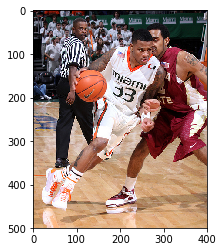

Greedy: two men play basketball


In [398]:
import matplotlib.pyplot as plt
z= 865
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))